__File: srg_observables_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     August 28, 2019__

This notebook creates a few figures showing phase shifts and momentum distributions from NN potentials for initial or SRG-evolved potentials. Each function creates and saves a figure to the __Figures/SRG_observables__ folder. Below is an outline of each function:
* phase_shifts - Plots NN phase shifts from several potentials.
* deuteron_momentum_distribution - Plots a semi-log figure of deuteron momentum distributions comparing initial and SRG-evolved $\psi^2$. Note this depicts $\psi(s)^2$ not $|\psi(s)|^2 = \psi^{\dagger}(0) U^{\dagger}(s) U(s) \psi(0) = |\psi(0)|^2$.
* continuum_state_distribution - Analog of the deuteron_momentum_distribution function but for some state $\epsilon_k$ > 0 MeV.

__Revision history:<br/>__
* August 30, 2019 - Finalized phase_shifts, deuteron_momentum_distribution, and continuum_state_distribution functions.
* September 5, 2019 - Generalized functional arguments. This is helpful for plotting several curves on the same figure.
* September 9, 2019 - Generalized phase_shifts and continuum_state_momentum_distribution to plot for any partial wave channel.

In [1]:
from os import chdir, getcwd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
# Scripts made by A.T.
from Figures import figures_functions as ff
from Potentials.vsrg_macos import load_save_potentials as lp
import observables as ob
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

__Plotting functions__

In [2]:
def phase_shifts(channel, *potentials):
    """
    Plots NN phase shifts [deg] as a function of momentum [fm^-1] for several potentials. Must specify the partial
    wave channel and each potential of interest.
    
    Parameters
    ----------
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    *potentials : tuple
        Specifications for phase shifts corresponding to an NN potential in the format (kvnn, kmax, kmid, ntot) 
        where kvnn (int) is the number specifying the potential, kmax (float) is the maximum value in the momentum
        mesh, kmid (float) is the mid-point value in the mesh, and ntot (int) is the number of points in the mesh.
        For example, (10, 30.0, 4.0, 120) corresponds to the default Entem-Machleidt N3LO potential.

    Saves
    -----
    file_name = phase_shifts_ with an extension based off the given argument. For example,
                phase_shifts_3S1_kvnns_10_106_222.pdf.
    
    """
    
    
    # Check that at least one potential was provided
    if not potentials: 
        print('At least one potential must be specified.')
        return None
    
    
    # --- Set-up --- #
    
    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_M = 41.47

    # Relative momentum in fm^-1
    k_max = 4.0
    M = 200 # Number of points in array
    k_points = np.linspace(0.01, k_max, M)
    # We could also plot phase shifts w.r.t to E_lab but we choose k for comparison to potential matrix elements
    # in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_M * k_points**2 
    
    # Limits of x and y axes and location of labels
    xlim = [0.0, k_max]
    if channel == '1S0':
        ylim = [-80.0, 70.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    elif channel == '3S1':
        ylim = [-40.0, 180.0]
        legend_label_location = 'upper right'
        channel_label_location = 'lower left'
    elif channel == '1P1':
        ylim = [-60.0, 10.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper center'
    else:
        ylim = [-40.0, 180.0]
        legend_label_location = 'lower left'
        channel_label_location = 'upper right'
    
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label = r'$\delta$' + ' [deg]'
    channel_label = ff.channel_label_conversion(channel)
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 14
    channel_label_size = 22
    
    # Initialize file name of figure
    file_name = 'phase_shifts_%s_' % channel + 'kvnns' # This reads 'phase_shifts_3S1_kvnns_'
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4)) # This gives a square figure
    
    # Loop over specifications keeping track of the curve number i
    i = 0
    for potential in potentials:
        
        # Set kvnn, kmax, and kmid
        kvnn = potential[0]
        kmax = potential[1]
        kmid = potential[2]
        ntot = potential[3]
        
        # Update name of the file (based off kvnn)
        file_name += '_' + str(kvnn)
        
        # Load momentum, weights, and potential
        k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot)
        V_matrix = lp.load_potential(kvnn, channel, kmax, kmid, ntot)
    
        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
        else:
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i) # Color
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.kvnn_label_conversion(kvnn) # Legend label
        
        # Add to figure
        ax.plot(k_points, delta_array, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
        
    # --- Set figure specifications and save --- #

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add channel as anchored text
    anchored_text = AnchoredText(channel_label, prop=dict(size=channel_label_size), loc=channel_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)
    
    # Save figure
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [3]:
def deuteron_momentum_distribution(kvnn, kmax, kmid, ntot, lamb, *generators):
    """
    Plots a semi-log figure of the deuteron momentum distribution |psi_d(k)|^2 [fm^3] as a function of momentum k 
    [fm^-1] with psi_d(0) from the bare Hamiltonian and psi_d(lambda) from several evolved Hamiltonians at a given 
    value of lambda. Must specify details the potential, hence the arguments kvnn, kmax, etc. Furthermore, must
    specify the generators and SRG lambda.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    lamb : float
        Evolution parameter lambda in units fm^-1.
    *generators : str
        SRG generators. For the block-diagonal generator, one must specify the decoupling parameter Lambda_BD. This
        is done by writing generator = 'Block-diag_float' where float is the Lambda_BD value in fm^-1. For example,
        'Wegner', 'Block-diag_2.00', 'Block-diag_3.00' would give three evolved distributions in addition to the
        initial momentum distribution.

    Saves
    -----
    file_name = deuteron_momentum_distribution_ with an extension based off the given arguments. For example,
                deuteron_momentum_distribution_kvnn10_Block-diag_2,00_lamb1,5.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
    phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
    
    # Limits of x and y axes
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label = r'$\phi_d^2$' + ' [fm' + r'$^3$' + ']'
    lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 14
    lambda_label_size = 14
    
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'lower left'
    
    # Initialize file name of figure
    # This reads 'deuteron_momentum_distribution_kvnn##_' where ## is an integer number
    file_name = 'deuteron_momentum_distribution_kvnn%d_' % kvnn 
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4)) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0
    for generator in generators:
        
        # If block-diagonal generator, obtain lambda_bd and set generator = 'Block-diag'. Otherwise, set lambda_bd
        # to zero (irrelevant argument)
        if generator[:10] == 'Block-diag':
            gen, lambda_bd_str = generator.split('_')
            lambda_bd = float(lambda_bd_str)
        else:
            gen = generator
            lambda_bd = 0
            
        # Update name of the file (based off generator)
        file_name += '_' + generator
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', gen, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
        
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(gen, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)

    # Name of the file
    file_name += '_' + 'lamb%.1f' % lamb
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

In [4]:
def continuum_state_momentum_distribution(eps, kvnn, channel, kmax, kmid, ntot, lamb, *generators):
    """
    Plots a semi-log figure of the momentum distribution |psi_eps(k)|^2 [fm^3] as a function of momentum k [fm^-1]
    with psi_eps(0) from the bare Hamiltonian and psi_eps(lambda) from several evolved Hamiltonians at a given 
    value of lambda. Epsilon specifies the energy of the state (i.e. epsilon = -2.22 MeV would corrspond to 
    deuteron in 3S1 channel). Must specify details the potential, hence the arguments kvnn, kmax, channel, etc.
    Furthermore, must specify the generators and SRG lambda.
    
    Parameters
    ----------
    eps : float
        Energy value in units MeV.
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel ('1S0', '3S1', etc.)
    kmax : float
        Maximum value in the momentum mesh.
    kmid : float
        Mid-point value in the momentum mesh.
    ntot : int
        Number of momentum points in mesh.
    lamb : float
        Evolution parameter lambda in units fm^-1.
    *generators : str
        SRG generators. For the block-diagonal generator, one must specify the decoupling parameter Lambda_BD. This
        is done by writing generator = 'Block-diag_float' where float is the Lambda_BD value in fm^-1. For example,
        'Wegner', 'Block-diag_2.00', 'Block-diag_3.00' would give three evolved distributions in addition to the
        initial momentum distribution.

    Saves
    -----
    file_name = continuum_state_momentum_distribution_ with an extension based off the given arguments. For example,
                continuum_state_momentum_distribution_eps200_kvnn10_3S1_Block-diag_2,00_lamb1,5.pdf.
    
    """
    
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    

    # --- Set-up --- #
    
    # Coupled-channel?
    coupled_channel = lp.coupled_channel(channel) # This is a boolean variable
    
    # Load initial Hamiltonian, momentum, and weights
    H_initial = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
    k_array, k_weights = lp.load_momentum(kvnn, channel, kmax, kmid, ntot) 
    
    # Compute initial wave function
    psi_initial = ob.wave_function(H_initial, eps)
    
    # Coupled-channel
    if coupled_channel:
        
        u_initial = psi_initial[:ntot] # 3S1 component
        w_initial = psi_initial[ntot:] # 3D1 component
        
        # Initial momentum distribution (divide by momenta and weights for mesh-independent result)
        phi_squared_initial = ( u_initial**2 + w_initial**2 ) / ( k_array**2 * k_weights )
        
    else:
        
        phi_squared_initial = psi_initial**2 / ( k_array**2 * k_weights )
    
    # Limits of x and y axes
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e2]
    
    # Labels
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    y_label = r'$\phi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
    lambda_inf_label =r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
    
    # Fontsize for labels
    x_label_size = 18
    y_label_size = 20
    legend_label_size = 10
    lambda_label_size = 14
    
    # Location of labels
    legend_label_location = 'upper right'
    lambda_label_location = 'upper left'
    
    # Initialize file name of figure
    # This reads 'continuum_state_momentum_distribution_eps##_kvnn##_channel' where ## are numbers
    file_name = 'continuum_state_momentum_distribution_eps%.1f_kvnn%d_%s' % (eps, kvnn, channel)
    
    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot lines --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4)) # This gives a square figure
    
    # Loop over generators keeping track of the curve number i
    i = 0
    for generator in generators:
        
        # If block-diagonal generator, obtain lambda_bd and set generator = 'Block-diag'. Otherwise, set lambda_bd
        # to zero (irrelevant argument)
        if generator[:10] == 'Block-diag':
            lambda_bd = float( generator[11:] )
            gen = generator[:10]
        else:
            gen = generator
            lambda_bd = 0
            
        # Update name of the file (based off generator)
        file_name += '_' + generator
            
        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = lp.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, 'srg', gen, lamb, lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix)
        
        # Coupled-channel
        if coupled_channel:
        
            u_evolved = psi_evolved[:ntot] # 3S1 component
            w_evolved = psi_evolved[ntot:] # 3D1 component
            
            # Evolved momentum distribution (divide by momenta and weights for mesh-independent result)
            phi_squared_evolved = ( u_evolved**2 + w_evolved**2 ) / ( k_array**2 * k_weights )
            
        else:
            
            phi_squared_evolved = psi_evolved**2 / ( k_array**2 * k_weights )
            
        # Curve labels and styles
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        curve_style = ff.line_styles(i) # Linestyle
        curve_label = ff.generator_label_conversion(gen, lambda_bd) # Legend label
        
        # Add to figure
        ax.semilogy(k_array, phi_squared_evolved, color=curve_color, linestyle=curve_style, label=curve_label)
        
        i += 1
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(i) # Linestyle
    curve_label = lambda_inf_label # Legend label
    
    # Add to figure
    ax.semilogy(k_array, phi_squared_initial, color=curve_color, linestyle=curve_style, label=curve_label)

    
    # --- Set figure specifications and save --- #
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    # Add legend
    ax.legend(loc=legend_label_location, frameon=False, fontsize=legend_label_size)
    # Add lambda label as anchored text
    anchored_text = AnchoredText(lambda_label, prop=dict(size=lambda_label_size), loc=lambda_label_location,
                                 frameon=False)
    ax.add_artist(anchored_text)

    # Name of the file
    file_name += '_' + 'lamb%.1f' % lamb
    # Replace '.' with ',' in file name since LaTeX doesn't like periods
    file_name = ff.replace_periods_with_commas(file_name)
    
    # Save figure
    chdir('Figures/SRG_observables')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

__Run functions in the cells below:__

In [5]:
# Fixed variables


ntot = 120

# Potentials formatted as (kvnn, kmax, kmid, ntot) tuples
# EM N3LO non-local potential at cutoff of 500 MeV
em_n3lo = (10, 30.0, 4.0, ntot)
# RKE N3LO semi-local potential at cutoff of 450 MeV
rke_n3lo = (106, 8.0, 2.0, ntot)
# Gezerlis et al N2LO local at cutoff 1.0 fm
gez_n2lo = (222, 10.0, 2.0, ntot)

# SRG decoupling parameter lambda in units fm^-1
lamb = 1.5

In [6]:
# Plot EM N3LO, RKE N3LO, and Gez. N2LO phase shifts


# 1S0 channel
#phase_shifts('1S0', em_n3lo, rke_n3lo, gez_n2lo)
# 3S1 channel
#phase_shifts('3S1', em_n3lo, rke_n3lo, gez_n2lo)
# 1P1 channel
#phase_shifts('1P1', em_n3lo, rke_n3lo, gez_n2lo)

In [7]:
# Plot deuteron momentum distributions


# EM N3LO non-local potential at cutoff of 500 MeV (varying SRG generator)
#deuteron_momentum_distribution(10, 30.0, 4.0, ntot, lamb, 'Wegner', 'Block-diag_2.00', 'Block-diag_3.00')

# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
#deuteron_momentum_distribution(106, 8.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00', 'Block-diag_3.00')

# Gezerlis et al N2LO local at cutoff 1.0 fm (varying SRG generator)
#deuteron_momentum_distribution(222, 10.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00', 'Block-diag_3.00')

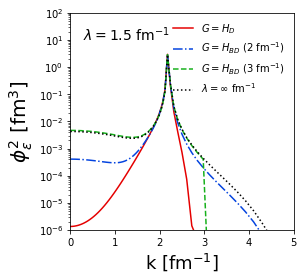

In [8]:
# Plot continuum state momentum distributions


# Energy of the state in MeV
eps = 200

# EM N3LO non-local potential at cutoff of 500 MeV (varying SRG generator)
#continuum_state_momentum_distribution(eps, 10, '3S1', 30.0, 4.0, ntot, lamb, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')

# RKE N3LO semi-local potential at cutoff of 450 MeV (varying SRG generator)
#continuum_state_momentum_distribution(eps, 106, '3S1', 8.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')

# Gezerlis et al N2LO local at cutoff 1.0 fm (varying SRG generator)
#continuum_state_momentum_distribution(eps, 222, '3S1', 10.0, 2.0, ntot, lamb, 'Wegner', 'Block-diag_2.00',
                                      #'Block-diag_3.00')